Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [54]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib as plt
import seaborn as sns
from scipy.stats import chisquare

In [55]:
df = pd.read_csv('C:/Users/Влад Чубенко/Downloads/Проект_1_Задание_2.csv', sep = ';') # читаем файл

In [56]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [58]:
df.duplicated().sum() # проверяем на дубликаты

0

In [59]:
# При таких данных целеообразно посмотреть на выручку, ARPPU, ARPU и конверсию.

In [60]:
df.testgroup.value_counts() # количество пользователей в группах

b    202667
a    202103
Name: testgroup, dtype: int64

In [61]:
# Посмотрим на распределение revenue в группах

<AxesSubplot:ylabel='Frequency'>

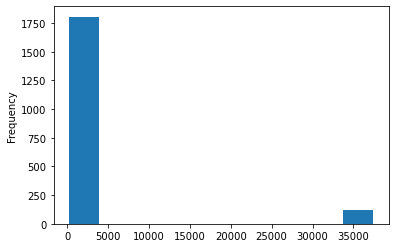

In [62]:
df.query("testgroup == 'a' & revenue > 0").revenue.plot.hist()

<AxesSubplot:ylabel='Frequency'>

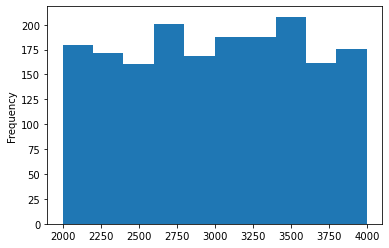

In [63]:
df.query("testgroup == 'b' & revenue > 0").revenue.plot.hist()

<AxesSubplot:xlabel='revenue', ylabel='testgroup'>

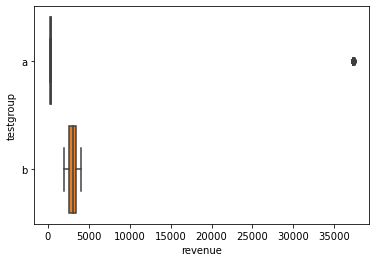

In [64]:
sns.boxplot(x = 'revenue', y = 'testgroup', data = df.query("revenue > 0"))

In [65]:
# Проверим выполнение условий на нормальность распределений методом Шапиро-Уилка

In [66]:
stats.shapiro(df[df['testgroup'] == 'a'].revenue.sample(1000))

ShapiroResult(statistic=0.01330113410949707, pvalue=0.0)

In [67]:
stats.shapiro(df[df['testgroup'] == 'b'].revenue.sample(1000))

ShapiroResult(statistic=0.0420646071434021, pvalue=0.0)

In [68]:
# Результаты теста показывают, что распределения ненормальны.
# проведем тест на гомогенность дисперсий, чтобы понять, сможем ли использовать t-test при дальнейшей оценке результатов


In [69]:
stats.levene(df[df['testgroup'] == 'a'].revenue, df[df['testgroup'] == 'b'].revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

In [70]:
# Согласно результатам теста мы не можем отклонить нулевую гипотезу, требование гомогенности дисперсий соблюдается,
# следовательно мы можем использовать t-test

In [71]:
# Посчитаем максимальный чек, ARPPU и ARPU

In [72]:
df[df['testgroup'] == 'a'].revenue.sum() #общая сумма выручки в группе "а"

5136189

In [73]:
df[df['testgroup'] == 'b'].revenue.sum() #общая сумма выручки в группе "b"

5421603

In [74]:
#максимальные чеки

In [75]:
df.query("testgroup == 'a' & revenue > 0").revenue.max() #максимальный чек группы "а"

37433

In [76]:
df.query("testgroup == 'a' & revenue > 0 & revenue < 37200").revenue.max() #Максимальный чек группы "а", исключая выбросы

400

In [77]:
df.query("testgroup == 'b' & revenue > 0").revenue.max() #максимальный чек группы "b"

4000

In [78]:
#ARPPU

In [79]:
df.query("testgroup == 'a' & revenue > 0").revenue.mean() #ARPPU для группы "а"

2663.9984439834025

In [80]:
df.query("testgroup == 'a' & revenue > 0 & revenue < 37200").revenue.mean() #ARPPU для группы "а" без аномально крупных чеков

302.45817174515236

In [81]:
df.query("testgroup == 'b' & revenue > 0").revenue.mean() #ARPPU для группы "b"

3003.6581717451522

In [82]:
stats.ttest_ind(df.query("testgroup == 'b' & revenue > 0").revenue, df.query("testgroup == 'a' & revenue > 0").revenue)

Ttest_indResult(statistic=1.5917100176862002, pvalue=0.11153459157259504)

In [83]:
stats.ttest_ind(df.query("testgroup == 'b' & revenue > 0").revenue, df.query("testgroup == 'a' & revenue > 0 & revenue < 37200").revenue)

Ttest_indResult(statistic=199.39722533995328, pvalue=0.0)

In [84]:
# В случае проведения теста, не исключающего крупные чеки из группы "a", p-value > 0.05, не фиксируем статзначимые различия
# В обратном случае p-value < 0.05, различия наблюдаются

In [85]:
#ARPU

In [86]:
df.groupby('testgroup', as_index = False).agg({'revenue':'mean'}) #ARPU

,testgroup,revenue
0,a,25.413720
1,b,26.751287


In [87]:
stats.ttest_ind(df[df['testgroup'] == 'a'].revenue, df[df['testgroup'] == 'b'].revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

In [88]:
# p-value > 0.05 Не отклоняем нулевую гипотезу, не наблюдаем статзначимых различий

In [89]:
#считаем конверсию

In [90]:
df.query("testgroup == 'a' & revenue > 0").user_id.count()/df[df.testgroup == 'a'].user_id.count()*100 #конверсия в группе "а"

0.9539690157988748

In [91]:
df.query("testgroup == 'a' & revenue > 0 & revenue<37000").user_id.count()/df[df.testgroup == 'a'].user_id.count()*100
# конверсия в группе "а" без крупных чеков

0.8931089592930338

In [92]:
df.query("testgroup == 'b' & revenue > 0").user_id.count()/df[df.testgroup == 'b'].user_id.count()*100 #конверсия в группе "b"

0.8906235351586593

In [93]:
# Для проведения теста хи-квадрат создадим новую колонку purchase

In [94]:
purchase = []
for i in df.revenue:
    if i == 0:
        x = 'no'
    else:
        x = 'yes'
    purchase.append(x)
df['purchase'] = purchase    

In [95]:
df.groupby(['purchase', 'testgroup'], as_index=False).agg({'user_id': 'nunique'})

,purchase,testgroup,user_id
0,no,a,200175
1,no,b,200862
2,yes,a,1928
3,yes,b,1805


In [96]:
pd.crosstab(df['testgroup'], df['purchase'])

purchase,no,yes
testgroup,,
a,200175,1928
b,200862,1805


In [97]:
stats.chi2_contingency(pd.crosstab(df['testgroup'], df['purchase']))

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104,   1863.89924896],
        [200797.89924896,   1869.10075104]]))

In [98]:
# p-value < 0.05, имеются статзначимые различия в конверсиях групп

Проанализировав результаты A/B теста, можно сказать следующее:
в группах очень разный масштаб покупок, в "а" совершено много покупок в малом ценовом диапазоне до 400 рублей, но присутствуют заказы по 37000.
В группе "b" в свою очередь покупки стабильно высокие.
В целом, все метрики, кроме конверсии выше в группе "b" (выручка, ARPU, ARPPU). 
Статзначимые различия наблюдаем в случае конверсии. 
Рекомендовал бы выбрать набор "b", поскольку пользователи стабильно покупали акционные наборы по достаточно высокой цене.
Стоит сказать, что нам не дана цель исследования: если она состояла в том, чтобы продать некие наборы по очень высокой цене, то группа "а" с ней справилась.